# 处理文本数据

1. [n-grams & bag-of-words](#1.-n-gram-和词袋-(bag-of-words))
2. [word/character-level one-hot encoding](#2.-单词/字符的-one-hot-encoding)
  - [hands-on word-level one-hot encoding](#2.1-手写单词级-ont-hot-编码)
  - [hands-on character-level one-hot encoding](#2.2-手写字符级-one-hot-编码)
  - [`tf.keras` word-level one-hot encoding](#2.3-tf.keras-实现单词级-one-hot-编码)
  - [`tf.keras` character-level one-hot encoding](#2.4-tf.keras-实现字符级-one-hot-编码)
  - [one-hot-hashing-trick](#2.5-one-hot-散列技巧-(one-hot-hashing-trick))
3. [word embedding](#3.-Word-embedding)
  - [hands-on word embedding](#3.1-利用-Embedding-层学习-word-embedding)
  - [pretrained word embedding](#3.2-使用-pretrained-word-embedding)

文本是最常用的序列数据之一，可以理解为字符序列或单词序列，但最常见的是单词级处理。

<font color='crimson'>chap6 介绍的 DL 模型都没有像人类一样真正地理解文本，而只是映射出书面语言的统计结构，但这足以解决许多简单的文本任务。</font>

DL 用于自然语言处理是将模式识别应用于单词、句子和段落，这与计算机视觉是将模式识别应用于像素大致相同。

<br>

**<font color='blue'>文本向量化 (vectorize) 是指将文本转换为数值张量的过程</font>**，方法有：

- <font color='blue'>将文本分割为单词 (word)，并将每个单词转换为一个向量</font>


- <font color='blue'>将文本分割为字符，并将每个字符转换为一个向量</font>


- <font color='blue'>提取单词或字符的 n-gram，并将每个 n-gram 转换为一个向量</font>。 n-gram 是多个连续单词或字符的集合 (n-gram 之间可重叠)

将文本分解而成的单元 (单词、字符或 n-gram) 叫作**<font color='red'>标记 (token)</font>** ，将文本分解成标记的过程叫作**<font color='red'>分词 (tokenization)</font>** 。

<font color='blue'>所有文本向量化过程都是应用某种分词方案，然后将数值向量与生成的标记相关联。这些向量组合成序列张量，被输入到深度神经网络中。</font>

<br>

**<font color='crimson'>将向量与 token 相关联的方法：</font>**

- <font color='crimson'>对 token 做 one-hot 编码 (one-hot encoding)</font>


- <font color='crimson'>token embedding</font>，用于单词，叫作 <font color='crimson'>word embedding</font>

## 1. n-gram 和词袋 (bag-of-words)

<font color='crimson'>n-gram 是从一个句子中提取的 N 个 (或更少) 连续单词 (或字符) 的集合。</font>

考虑句子——**"The cat sat on the mat."**

- 其 2-gram 集合为：

  {"The", "The cat", "cat", "cat sat", "sat", "sat on", "on", "on the", "the", "the mat", "mat"}


- 其 3-gram 集合为：

  {"The", "The cat", "cat", "cat sat", "The cat sat", "sat", "sat on", "on", "cat sat on", "on the", "the", "sat on the", "the mat", "mat", "on the mat"}

分别称为**<font color='red'>二元语法袋 (bag-of-2-grams)</font>** 和**<font color='red'>三元语法袋 (bag-of-3-grams)</font>** 。**<font color='red'>袋 (bag)</font>** 是指我们处理的是 token 组成的<font color='crimson'>集合</font>，而不是一个列表或序列，即<font color='crimson'> token 没有特定的顺序</font>。这一系列的分词方法叫作**<font color='red'>法袋 (bag-of-words)</font>** 。

<br>

<div class="alert alert-block alert-info">
    <b>bag-of-words 是一种不保存顺序的分词方法 (生成的标记组成一个集合，而不是一个序列，舍弃了句子的总体结构)</b>，因此它<b>往往被用于浅层的语言处理模型，而不是 DL 模型</b>。<br><br>
提取 n-gram 是一种特征工程，DL 不需要这种死板而又不稳定的方法，并将其替换为分层特征学习。 <b>RNN 和 Conv1D 都能够通过观察连续的单词或字符序列来学习单词组/字符组的数据表示，而无须明确知道这些的存在</b>。<br><br>
    <font color='blue'>在使用轻量级的浅层文本处理模型 (如 LR 和 RF) 时，n-gram 是一种功能强大、不可或缺的特征工程工具。</font>
</div>

## 2. 单词/字符的 one-hot encoding

one-hot 编码是将标记转换为向量的最常用、最基本的方法。

<font color='crimson'>将每个单词/字符与一个唯一的整数索引相关联，然后将这个整数索引 i 转换为长度为 N 的二进制向量 (N 是单词/字符表大小)，这个向量只有第 i 个元 素是 1，其余元素都为 0。</font>

In [1]:
# Common imports
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(42)
tf.random.set_seed(42)

tf.__version__

'2.1.0'

### 2.1 手写单词级 ont-hot 编码

In [2]:
# 单词级的 one-hot 编码
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            # 为每个单词指定一个唯一index
            # 没有为 index 0 指定单词
            token_index[word] = len(token_index) + 1

# 对样本进行分词，只考虑每个样本的前 max_length 个单词
max_length = 10
results = np.zeros(shape=(len(samples),
                          max_length,
                          # max(token_index.values()) + 1
                          len(token_index)+1))

for i, sample in enumerate(samples):
    # 只考虑每个样本的前 max_length 个单词
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1

In [3]:
token_index  # 单词-index 对应关系从 index=0 开始

{'The': 1,
 'cat': 2,
 'sat': 3,
 'on': 4,
 'the': 5,
 'mat.': 6,
 'dog': 7,
 'ate': 8,
 'my': 9,
 'homework.': 10}

In [4]:
results

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0

### 2.2 手写字符级 one-hot 编码

In [5]:
import string

string.printable  # 所有可打印的 ASCII 字符

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [6]:
# character-level 的 one-hot 编码
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable  # 所有可打印的 ASCII 字符
# 为每个单词指定一个唯一index，但不为 index 0 指定单词
token_index = dict(zip(characters, range(1, len(characters)+1)))

# 只考虑每个样本的前 50 个字符
max_length = 50
results = np.zeros(shape=(len(samples),
                          max_length,
                          len(token_index)+1))
for i, sample in enumerate(samples):
    # 只考虑每个样本的前 50 个字符
    for j, character in enumerate(sample[:max_length]):
        index = token_index.get(character)
        results[i, j, index] = 1.

In [7]:
# character-index 对应关系从 index=0 开始
for k, v in token_index.items():
    print("First (key, value)")
    print("character: {}, index: {}".format(k, v))
    break

First (key, value)
character: 0, index: 1


### 2.3 `tf.keras` 实现单词级 one-hot 编码

**`tf.keras.preprocessing.text.Tokenizer(num_words=1000)`** 中 `num_words` 为需要保留的最大单词数 (基于词频)。**只有**最常出现的 `num_words-1` 个单词被保留。

默认情况下，删除所有标点符号，将文本转换为空格分隔的单词序列（单词可能包含 `'` 字符）。 这些序列然后被分割成标记列表。然后它们将被索引或向量化。

**<font color='blue'>0 是不会被分配给任何单词的保留索引。</font>**

In [8]:
# tf.keras 实现 单词级的 one-hot 编码
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# 基于词频，需要保留的最大单词数，
# 只有最常出现的 num_words-1 个被保留。
# 0 是不会被分配给任何单词的保留索引
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)
# Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(samples)

# Transforms each text in texts to a sequence of integers.
# Only top `num_words-1` most frequent words will be taken into account.
# Only words known by the tokenizer will be taken into account.
sequences = tokenizer.texts_to_sequences(samples)
# Convert a list of texts to a Numpy matrix.
# one of "binary", "count", "tfidf", "freq".
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index

In [9]:
# Returns the tokenizer configuration as Python dictionary.
tokenizer.get_config()

{'num_words': 1000,
 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': None,
 'document_count': 2,
 'word_counts': '{"the": 3, "cat": 1, "sat": 1, "on": 1, "mat": 1, "dog": 1, "ate": 1, "my": 1, "homework": 1}',
 'word_docs': '{"on": 1, "mat": 1, "the": 2, "cat": 1, "sat": 1, "my": 1, "dog": 1, "homework": 1, "ate": 1}',
 'index_docs': '{"4": 1, "5": 1, "1": 2, "2": 1, "3": 1, "8": 1, "6": 1, "9": 1, "7": 1}',
 'index_word': '{"1": "the", "2": "cat", "3": "sat", "4": "on", "5": "mat", "6": "dog", "7": "ate", "8": "my", "9": "homework"}',
 'word_index': '{"the": 1, "cat": 2, "sat": 3, "on": 4, "mat": 5, "dog": 6, "ate": 7, "my": 8, "homework": 9}'}

In [10]:
samples

['The cat sat on the mat.', 'The dog ate my homework.']

In [11]:
sequences

[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

In [12]:
one_hot_results.shape

(2, 1000)

In [13]:
one_hot_results

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

### 2.4 `tf.keras` 实现字符级 one-hot 编码

In [14]:
# tf.keras 实现字符级的 one-hot 编码
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000,
                                                  char_level=True)
# Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(samples)

# Transforms each text in texts to a sequence of integers.
# Only top `num_words-1` most frequent words will be taken into account.
# Only words known by the tokenizer will be taken into account.
sequences = tokenizer.texts_to_sequences(samples)
# Convert a list of texts to a Numpy matrix.
# one of "binary", "count", "tfidf", "freq".
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index

In [15]:
word_index  # index 从 1 开始

{' ': 1,
 't': 2,
 'e': 3,
 'h': 4,
 'a': 5,
 'o': 6,
 'm': 7,
 '.': 8,
 'c': 9,
 's': 10,
 'n': 11,
 'd': 12,
 'g': 13,
 'y': 14,
 'w': 15,
 'r': 16,
 'k': 17}

In [16]:
one_hot_results

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

### 2.5 one-hot 散列技巧 (one-hot hashing trick)

one-hot 编码的一种变体是所谓的 **<font color='red'>one-hot 散列技巧 (one-hot hashing trick)</font>**。

<font color='crimson'>如果词表中唯一标记的数量太大而无法直接处理，就可以使用这种技巧。</font>

这种方法<font color='crimson'>没有为每个单词显式分配一个索引并将这些索引保存在一个字典中，而是将单词散列编码为固定长度的向量，通常用一个非常简单的散列函数来实现</font>。

这种方法的主要优点在于，它<font color='blue'>避免了维护一个显式的单词索引，从而节省内存并允许数据的在线编码 (在读取完所有数据之前，你就可以立刻生成标记向量)</font>。
    
这种方法有一个缺点，就是<font color='blue'>可能会出现散列冲突 (hash collision)，即两个不同的单词可能具有相同的散列值，随后任何机器学习模型观察这些散列值，都无法区分它们所对应的单词</font>。如果散列空间的维度远大于需要散列的唯一标记的个数，散列冲突的可能性会减小。

In [17]:
# 使用散列技巧的单词级 one-hot 编码
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
# 将单词保存为长度为 1000 的向量
# 如果单词数量接近于 1000 个（或更多），那么会遇到散列冲突，会降低准确性
dimensionality = 1000
max_length = 100

results = np.zeros(shape=(len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        # 将单词散列为 0～1000 范围内的一个随机整数 index
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

In [18]:
results

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

## 3. Word embedding

将单词与向量相关联还有另一种常用的强大方法，就是使用密集的词向量 (word vector)， 也叫**<font color='red'>词嵌入 (word embedding)</font>**。

- <font color='blue'>one-hot 编码得到的向量是二进制的、稀疏的 (绝大部分元素都 是 0)、维度很高的 (维度大小等于词表中的单词个数)</font>


- <font color='blue'>word embedding是低维的浮点数向量(即密集向量，与稀疏向量相对)</font>

<font color='crimson'>与 one-hot 编码得到的词向量不同，词嵌入是从数据中学习得到的。</font>

<font color='crimson'>常见的 word embedding 维度是 256、512 或 1024 (处理非常大的词表时)</font>。与此相对，one-hot 编码的词向量维度通常为 20000 或更高 (对应包含 20000 个标记的词表)。因此，<font color='crimson'>word embedding 可以将更多的信息塞入更低的维度中</font>。

![word_embedding](figs/chap06-figs/word_embedding.png)

<div class="alert alert-block alert-info">
    <b><center>获得 word embedding 的 2 种方法</center></b><Br>
    1) <b>在完成主任务 (比如文档分类或情感预测) 的同时学习词嵌入。</b>在这种情况下，一开始是随机的词向量，然后对这些词向量进行学习，其学习方式与学习神经网络的权重相同。<br><br>
    2) <b>在不同于待解决问题的 ML 任务上预计算好 word embedding，然后将其加载到模型中</b>。这些 word embedding 叫作<font color='red'>预训练词嵌入 (pretrained word embedding)</font>。
</div>

### 3.1 利用 `Embedding` 层学习 word embedding

<font color='crimson'>要将一个词与一个密集向量相关联，最简单的方法就是随机选择向量。这种方法的问题在于，得到的嵌入空间没有任何结构。</font>

> accurate 和 exact 两个词的嵌入可能完全不同，尽管它们在大多数句子里都是可以互换的。DNN 很难对这种杂乱的、非结构化的嵌入空间进行学习。


<font color='blue'>词向量之间的几何关系应该表示这些词之间的语义关系。 word embedding 的作用应该是将人类的语言映射到几何空间中。</font>例如，<font color='crimson'>在一个合理的 word embedding 空间中，同义词应该被嵌入到相似的词向量中。</font> 一般来说，<font color='crimson'>任意两个词向量之间的几何距离 (比如 L2 距离) 应该和这两个词的语义距离有关 (表示不同事物的词被嵌入到相隔很远的点，而相关的词则更加靠近)</font>。除了距离，你可能<font color='crimson'>还希望嵌入空间中的特定方向也是有意义的</font>。为了更清楚地说明这一点，我们来 看一个具体示例。

> 图中，四个词被嵌入在二维平面上，这四个词分别是 cat (猫)、dog (狗)、wolf (狼) 和 tiger (虎)。对于我们这里选择的向量表示，这些词之间的某些语义关系可以被编码为几何 变换。例如，从 cat 到 tiger 的向量与从 dog 到 wolf 的向量相等，这个向量可以被解释为“从宠 物到野生动物”向量。同样，从 dog 到 cat 的向量与从 wolf 到 tiger 的向量也相等，它可以被解 释为“从犬科到猫科”向量。

在真实的 word embedding 空间中，常见的有意义的几何变换的例子包括“性别”向量和“复数”向量。 例如，将 king (国王) 向量加上 female (女性) 向量，得到的是 queen (女王) 向量。将 king (国王) 向量加上 plural (复数) 向量，得到的是 kings 向量。 **word embedding 空间通常具有几千个这种可解释的、 并且可能很有用的向量。**

有没有一个理想的 word embedding 空间，可以完美地映射人类语言，并可用于所有自然语言处理任 务?可能有，但我们尚未发现。此外，也不存在人类语言(human language)这种东西。世界上有许多种不同的语言，而且它们不是同构的，因为语言是特定文化和特定环境的反射。但从更实际的角度来说，**<font color='crimson'>一个好的 word embedding 空间在很大程度上取决于你的任务</font>**。英语电影评论情感分析 模型的完美 word embedding 空间，可能不同于英语法律文档分类模型的完美 word embedding 空间，<font color='crimson'>因为某些语义关系的重要性因任务而异</font>。

因此，**<font color='blue'>合理的做法是对每个新任务都学习一个新的嵌入空间</font>**。幸运的是，反向传播让这种学习变得很简单，而 Keras 使其变得更简单。我们要做的就是学习一个层的权重，这个层就是 **`Embedding`** 层。

In [19]:
# Turns positive integers (indexes) into dense vectors of fixed size.
# This layer can ONLY be used as the first layer in a model.
embedding_layer = tf.keras.layers.Embedding(
    # Size of the vocabulary, i.e. maximum integer index + 1.
    input_dim=1000,
    # Dimension of the dense embedding.
    output_dim=64,
    #  Length of input sequences, when it is constant. 
    input_length=None)
# embedding_layer = tf.keras.layers.Embedding(1000, 64)

In [20]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    # the largest integer (i.e. word index) in the input should be no larger
    # than 999 (vocabulary size)
    tf.keras.layers.Embedding(1000, 64, input_length=10)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 64)            64000     
Total params: 64,000
Trainable params: 64,000
Non-trainable params: 0
_________________________________________________________________


In [21]:
input_array = np.random.randint(1000, size=(32, 10))

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
assert output_array.shape == (32, 10, 64)

可以将 `Embedding` 层理解为一个字典，将整数索引 (表示特定单词) 映射为密集向量。它接收整数作为输入，并在内部字典中查找这些整数，然后返回相关联的向量。`Embedding` 层实际上是一种字典查找 (look-up)。

In [22]:
# model input shape: (samples, input_length)
model.input_shape

(None, 10)

<font color='crimson'>Embedding 层的输入是一个二维整数张量，shape 为 (samples, input_length)， 每个元素是一个整数序列。</font>它<font color='crimson'>能够嵌入长度可变的序列</font>，例如，对于前一个例子中的 Embedding 层，你可以输入形状为 (32, 10) (32 个长度为 10 的序列组成的批量) 或 (64, 15) (64 个长度为 15 的序列组成的批量) 的批量。<font color='crimson'>不过每个 batch 数据中的所有序列必须具有相同的长度</font> (因为需要将它们打包成一个张量)，所以<font color='crimson'>较短的序列应该用 0 填充，较长的序列应该被截断</font>。

In [23]:
# model input shape: (samples, input_length, embedding_dimensionality)
# 可以用 RNN 层或 Conv1D 层来处理这个三维张量
model.output_shape

(None, 10, 64)

**<font color='blue'>将一个 Embedding 层实例化时，它的权重 (即标记向量的内部字典) 最开始是随机的，与其他层一样。在训练过程中，利用反向传播来逐渐调节这些词向量，改变空间结构以便下游模型可以利用。一旦训练完成，嵌入空间将会展示大量结构，这种结构专门针对训练模型所要解决的问题。</font>**

In [24]:
# Load the IMDB data
from tensorflow.keras.datasets import imdb

max_features = 10000  # 作为特征的单词个数
maxlen = 20  # 每个 sample 只取前 20 个单词

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [25]:
x_train.shape, x_test.shape

((25000,), (25000,))

因为将电影评论限制为前 10000 个最常见的单词，所以数据集中最大的 index 为 9999，最小的 index 为 1，0 是不会被分配给任何单词的保留索引。

In [26]:
max(max(sample) for sample in x_train), min(min(sample) for sample in x_train)

(9999, 1)

In [27]:
# Preprocess the sequences
from tensorflow.keras.preprocessing import sequence

# Pads sequences to the same length.
x_train = sequence.pad_sequences(x_train, maxlen=maxlen, dtype='int32',
                                 padding='pre', truncating='pre', value=0.0)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen, dtype='int32',
                                 padding='pre', truncating='pre', value=0.0)

In [28]:
x_train.shape, x_test.shape

((25000, 20), (25000, 20))

In [29]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    # The input shape is `(samples, maxlen)`.
    # Argument `input_length` is required
    # if you are going to connect `Flatten` then `Dense` layers upstream
    # (without it, the shape of the dense outputs cannot be computed).
    tf.keras.layers.Embedding(10000, 8, input_length=maxlen),
    # After the `Embedding` layer, 
    # our activations have shape `(samples, maxlen, 8)`.

    # Flatten the 3D tensor of embeddings
    # into a 2D tensor of shape `(samples, maxlen * 8)`
    tf.keras.layers.Flatten(),

    # Add the classifier on top
    tf.keras.layers.Dense(1),
])
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    # The validation data is selected from the last samples
    # in the `x` and `y` data provided, before shuffling. 
    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 49us/sample - loss: 0.6709 - acc: 0.5084 - val_loss: 0.6221 - val_acc: 0.5778
Epoch 2/10
20000/20000 [==============================] - 1s 33us/sample - loss: 0.5456 - acc: 0.6842 - val_loss: 0.5294 - val_acc: 0.7080
Epoch 3/10
20000/20000 [==============================] - 1s 33us/sample - loss: 0.4622 - acc: 0.7642 - val_loss: 0.5032 - val_acc: 0.7360
Epoch 4/10
20000/20000 [==============================] - 1s 33us/sample - loss: 0.4209 - acc: 0.7941 - val_loss: 0.4960 - val_acc: 0.7388
Epoch 5/10
20000/20000 [==============================] - 1s 33us/sample - loss: 0.3930 - acc: 0.8116 - val_loss: 0.4962 - val_acc: 0.7402
Epoch 6/10
20000/20000 [==============================] - 1s 33us/sample - loss: 0.3708 - acc: 0.8273 - val_loss: 0.5020 - val_acc: 0.7508
Epoch 7/10
20000/20000 [==============================] - 1s 33us/sample - loss: 0.3513 - acc: 0.8390 - val_loss: 0.5

得到的验证精度约为 75%，考虑到仅查看每条评论的前 20 个单词，这个结果还是相当不错 的。

但请注意，**<font color='crimson'>仅仅将嵌入序列展开并在上面训练一个 `Dense` 层，会导致模型对输入序列中的每个单词单独处理，而没有考虑单词之间的关系和句子结构</font>** ( 举个例子，这个模型可能会将 this movie is a bomb 和 this movie is the bomb 两条都归为负面评论)。**<font color='crimson'>更好的做法是在嵌入序列上添加循环层或一维卷积层，将每个序列作为整体来学习特征。</font>** 这也是接下来几节的重点。

### 3.2 使用 pretrained word embedding

<font color='crimson'>当可用的训练数据很少，以至于只用手头数据无法学习适合特定任务的 word embedding，可以从预计算的嵌入空间中加载嵌入向量 (你知道这个嵌入空间是高度结构化的，并且具有有用的属性，即抓住了语言结构的一般特点)，而不是在解决问题的同时学习词嵌入。</font>

<font color='blue'>在 nlp 中使用预训练的 word embedding，其背后的原理与在图像分类中使用预训练的 convnet 是一样的：没有足够的数据来自己学习真正强大的特征，但需要的特征应该是非常通用的，比如常见的视觉特征或语义特征。在这种情况下，重复使用在其他问题上学到的特征，这种做法是有道理的。</font>

- <font color='blue'>word2vec</font> 算法由 Google 的 Tomas Mikolov 于 2013 年开发，其维度抓住了特定的语义属性，比如性别。


- <font color='blue'>GloVe</font> (global vectors for word representation，词表示全局向量)，由斯坦福大学的研究人员于 2014 年开发。这种嵌入方法基于对词共现统计矩阵进行因式分解。其开发者已经公开了数百万个英文标记的预计算嵌入，它们都是从维基百科数据和 Common Crawl 数据得到的。

**<font color='blueviolet'>1. 下载数据：</font>**

此处将使用 pretrained word embedding，将从头开始，先下载 IMDB 原始文本数据，而不是使用 Keras 内置的已经预先分好词的 IMDB 数据。

In [31]:
imdb_dir = '/Users/bingli/datasets/aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

texts, labels = [], []
for label_type in ['pos', 'neg']:
    dir_name = os.path.join(train_dir, label_type)
    for file_name in os.listdir(dir_name):
        if file_name[-4:] == '.txt':
            with open(os.path.join(dir_name, file_name), 'r') as f:
                texts.append(f.read())
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

**<font color='blueviolet'>2. 对数据进行分词：</font>**

对文本进行分词，并将其划分为训练集和验证集。

因为 <font color='crimson'>pretrained word embedding 对训练数据很少的问题特别有用</font> (否则，针对于具体任务的嵌入可能效果更好)， 所以我们又添加了以下限制: 将训练数据限定为前 200 个样本。

In [32]:
# pretrained word embedding 对训练数据很少的问题特别有用
training_samples = 200
val_samples = 10000

maxlen = 100       # 在 100 个单词截断评论
max_words = 10000  # 只考虑数据集中前 10000 个最常见的单词


# 基于词频，需要保留的最大单词数，
# 只有最常出现的 num_words-1 个被保留。
# 0 是不会被分配给任何单词的保留索引
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [33]:
word_index = tokenizer.word_index

print("Found {} unique tokens.".format(len(word_index)))

min(word_index.values()), max(word_index.values())

Found 88582 unique tokens.


(1, 88582)

In [34]:
# 只有数据中最常出现的 num_words-1=10000-1=9999 个单词被保留
max(max(sequence) for sequence in sequences)

9999

In [35]:
# Pad the sequence to the same length
data = tf.keras.preprocessing.sequence.pad_sequences(
    sequences,  # List of lists, where each element is a sequence.
    maxlen=maxlen,  # maximum length of all sequences.
    padding='pre',  # pad either before or after each sequence.
    # remove values from sequences larger than
    # `maxlen`, either at the beginning or at the end of the sequences.
    truncating='pre',
    value=0.0,  # Float or String, padding value.
)
data.shape

(25000, 100)

This function **transforms a list of `num_samples` sequences (lists of integers) into a 2D Numpy array of shape `(num_samples, num_timesteps`)**. `num_timesteps` is either the maxlen argument if provided, or the length of the longest sequence otherwise.

Sequences that are shorter than `num_timesteps` are padded with value at the end.

Sequences longer than `num_timesteps` are truncated so that they fit the desired length. 

The position where padding or truncation happens is determined by the arguments padding and truncating, respectively.

Pre-padding is the default.

In [36]:
labels = np.asarray(labels)

# Shuffle the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Split the data
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + val_samples]
y_val = labels[training_samples:training_samples + val_samples]

x_train.shape, x_val.shape

((200, 100), (10000, 100))

**<font color='blueviolet'>3. 预处理 pretrained word embedding：</font>**

对 pretrained word embedding 文件 (.txt 文件) 进行解析，构建一个单词（字符）映射为其向量表示（数值向量）的 index。

In [37]:
# pretrained word embedding 文件
glove_dir = '/Users/bingli/models/glove.6B/'
glove_embedding_path = os.path.join(glove_dir, 'glove.6B.100d.txt')

!head -n 2 /Users/bingli/models/glove.6B/glove.6B.100d.txt

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062
, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158 

In [38]:
# 解析 Glove word embedding 文件
embedding_index = {}  # {word: embedding_vector}
with open(glove_embedding_path, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print('Found {} word vectors.'.format(len(embedding_index)))

Found 400000 word vectors.


**<font color='crimson'>构建一个可以加载到 `Embedding` 层中的嵌入矩阵。</font>**

它必须是一个形状为 **`(max_words, embedding_dim)`** 的矩阵，<font color='crimson'>对于单词索引 (在分词时构建) 中索引为 i 的单词， 这个矩阵的元素 i 就是这个单词对应的 `embedding_dim` 维向量。</font>

**<font color='blue'>注意，索引 0 不应该代表任何 单词或标记，它只是一个占位符。</font>**

In [39]:
# 构建一个可以加载到 `Embedding` 层的词嵌入矩阵
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, index in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        # embedding_index 中招不到的词，其潜入向量全为 0
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [40]:
embedding_matrix.shape

(10000, 100)

In [41]:
embedding_matrix[:2]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

**<font color='blueviolet'>4. 构建模型</font>**

In [42]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words,
                              output_dim=embedding_dim,
                              input_length=maxlen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [43]:
# input shape : (samples, input_length)
# output shape: (samples, input_length, output_dim)
model.layers[0].input_shape, model.layers[0].output_shape

((None, 100), (None, 100, 100))

In [44]:
# Embedding 层只有一个权重，其 shape 为 (input_dim, output_dim)
model.layers[0].weights[0].shape

TensorShape([10000, 100])

**<font color='blueviolet'>5. 在模型中加载 pretrained word embedding</font>**

**`Embedding` 层只有一个权重矩阵，是一个二维的浮点数矩阵，其中每个元素 i 是与索引 i 相关联的词向量。够简单。将准备好的 GloVe 矩阵加载到 Embedding 层中，即模型的第一层。**

**需要冻结 `Embedding` 层 (即将其 `trainable` 属性设为 `False`)**，其原理和预训练的 convnet 相同。

<font color='crimson'>如果一个模型的一部分是经过预训练的 (如 `Embedding` 层)，而另一部分是随机初始化的 (如分类器)，那么在训练期间不应该更新预训练的部分，以避免丢失它们所保存的信息。随机初始化的层会引起较大的梯度更新，会破坏已经学到的特征。</font>

In [45]:
# 将 pertained word embedding 加载到 Embedding 层中
model.layers[0].set_weights([embedding_matrix])
# 冻结 Embedding 层，以避免丢失它们保存的信息
model.layers[0].trainabel = False

**<font color='blueviolet'>6. 训练模型</font>**


In [46]:
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save('./models/chap06-models/pretrained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.7259 - acc: 0.5000 - val_loss: 0.7284 - val_acc: 0.4992
Epoch 2/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.4833 - acc: 0.7650 - val_loss: 0.7885 - val_acc: 0.4998
Epoch 3/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.3510 - acc: 0.8650 - val_loss: 0.8857 - val_acc: 0.4989
Epoch 4/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.2466 - acc: 0.9300 - val_loss: 0.9688 - val_acc: 0.4963
Epoch 5/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.1648 - acc: 0.9600 - val_loss: 1.0716 - val_acc: 0.4973
Epoch 6/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.1080 - acc: 0.9650 - val_loss: 1.1840 - val_acc: 0.4970
Epoch 7/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.0703 - acc: 0.9850 - val_loss: 1.3056 - val_acc: 0.4945
Epoch 8/10
200

In [47]:
def plot_history(history):
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = [i + 1 for i in history.epoch]

    # Plot the results
    plt.figure(figsize=(14, 4.2))
    plt.subplot(121)
    plt.plot(epochs, loss_values, 'c+-', label='Training loss')
    plt.plot(epochs, val_loss_values, 'm.-', label='Val loss')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs, rotation=90)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=18)
    plt.title('Training and validation loss', fontsize=16)

    plt.subplot(122)
    plt.plot(epochs, acc, 'c+-', label='Training acc')
    plt.plot(epochs, val_acc, 'm.-', label='Val acc')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs, rotation=90)
    plt.ylabel('Acc', fontsize=12)
    plt.legend(fontsize=18)
    plt.title('Training and validation acc', fontsize=16)

    plt.show()

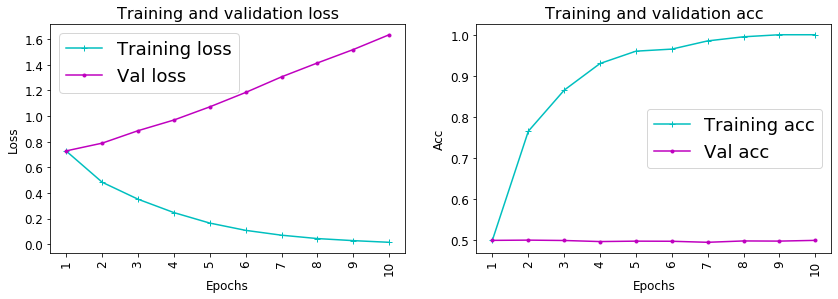

In [48]:
plot_history(history)

模型很快就开始过拟合，考虑到训练样本很少，这一点也不奇怪。出于同样的原因，验证精度的波动很大。

每次运行的结果可能会有所不同，因为训练样本数太少，所以模型性能严重依赖于你选择的 200 个样本，而样本是随机选择的。

In [49]:
# non pretrained word embedding
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.6930 - acc: 0.5100 - val_loss: 0.6955 - val_acc: 0.4954
Epoch 2/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.4754 - acc: 0.8100 - val_loss: 0.7101 - val_acc: 0.5042
Epoch 3/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.2500 - acc: 0.9750 - val_loss: 0.7159 - val_acc: 0.5122
Epoch 4/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.1063 - acc: 0.9900 - val_loss: 0.7148 - val_acc: 0.5391
Epoch 5/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.0519 - acc: 1.0000 - val_loss: 0.7150 - val_acc: 0.5172
Epoch 6/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.0250 - acc: 1.0000 - val_loss: 0.7203 - val_acc: 0.5230
Epoch 7/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.0138 - acc: 1.0000 - val_loss: 0.7335 - val_acc: 0.5238
Epoch 8/10
200

In [50]:
# 测试
test_dir = os.path.join(imdb_dir, 'test')

texts, labels = [], []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            with open(os.path.join(dir_name, fname)) as f:
                texts.append(f.read())
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)


sequences = tokenizer.texts_to_sequences(texts)
x_test = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

# Load the first model
model = tf.keras.models.load_model('./models/chap06-models/pretrained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 23us/sample - loss: 1.6301 - acc: 0.5045


[1.630081245956421, 0.50452]